In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona
import pyogrio


In [67]:
data = pd.read_csv('survey.csv')
data.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


## Data preprocessing

### Gender

In [68]:
data['Gender'] = data['Gender'].replace(['M', 'm', 'male', 'Male'], 'Male')
data['Gender'] = data['Gender'].replace(['F', 'f', 'female', 'Female'], 'Female')

data.loc[data['Gender'].str.contains('Fe', case=False), 'Gender'] = 'Female'
female_records = data[data['Gender'].str.contains('Female', case=False)]

other_records = data[~data['Gender'].str.contains('Female', case=False)]
other_records.loc[other_records['Gender'].str.contains('Ma', case=False), 'Gender'] = 'Male'

df = pd.concat([female_records, other_records])

# Filtrowanie do rekordów z 'Male' i 'Female'
df = df[df['Gender'].isin(['Female','Male'])]

print("Unique Gender values:", df['Gender'].unique())
print("New shape:", df.shape)


Unique Gender values: ['Female' 'Male']
New shape: (1244, 27)


### Age

In [69]:
df = df[df['Age']<100]
df = df[df['Age']>16]
print("New shape:", df.shape)


New shape: (1239, 27)


## Plots


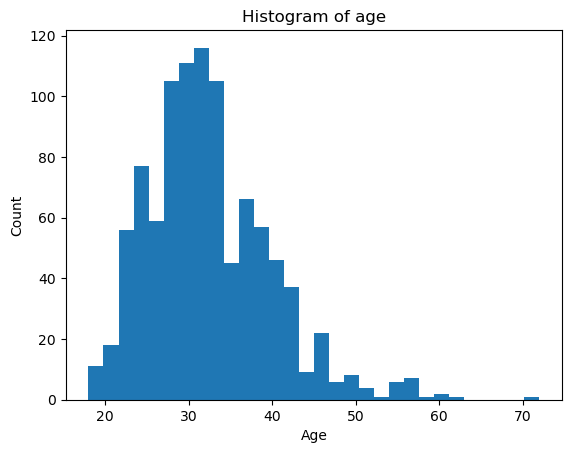

(1239, 27)
(977, 27)


In [70]:
df_sick = df[df['work_interfere'].isna()==False]
plt.hist(df_sick['Age'], bins= 30) 
plt.title('Histogram of age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()
print(df.shape)
print(df_sick.shape)

<Axes: xlabel='Gender'>

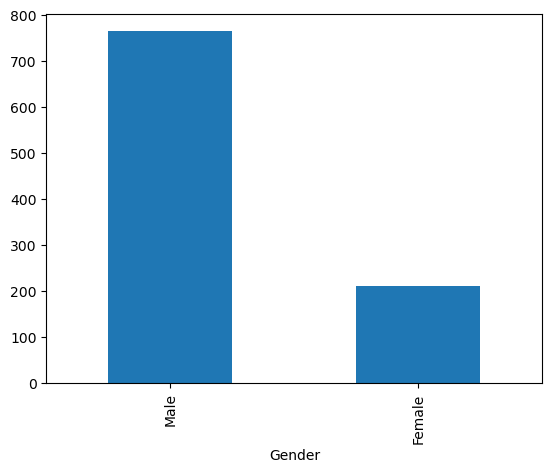

In [71]:
values = df_sick['Gender'].value_counts()
values.plot(kind='bar')

<Axes: title={'center': 'Age'}, ylabel='work_interfere'>

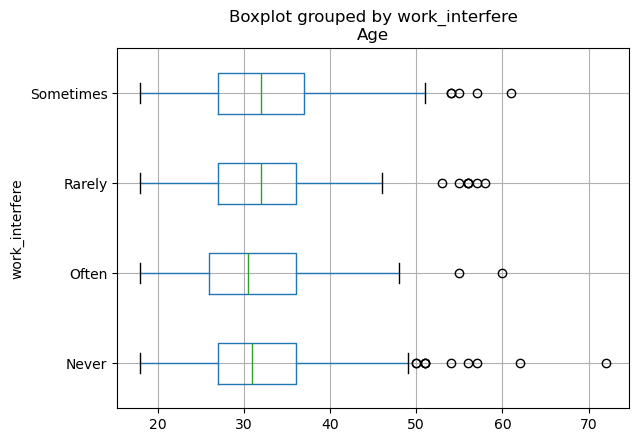

In [72]:
df_sick.boxplot(column = 'Age', by='work_interfere', vert=False)

Text(0, 0.5, 'Number of answers')

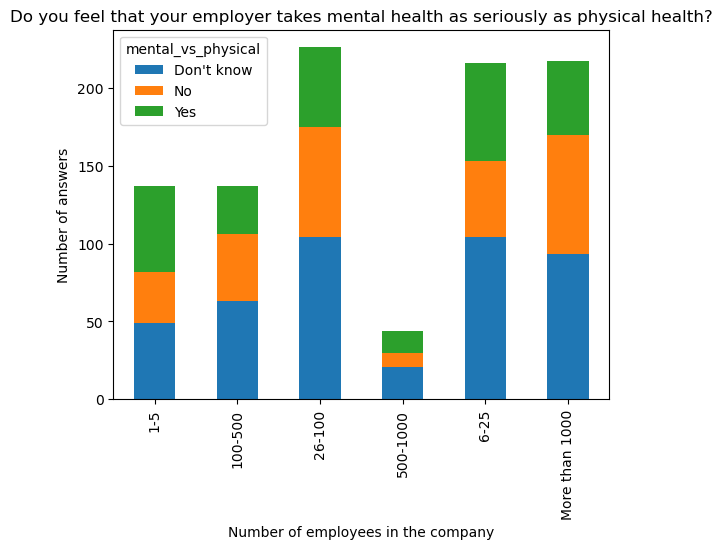

In [73]:
#mentalvspsychical rozmiar firmy
response_counts = df_sick.groupby('no_employees')['mental_vs_physical'].value_counts().unstack()
response_counts.plot(kind='bar', stacked=True)
plt.title('Do you feel that your employer takes mental health as seriously as physical health?')
plt.xlabel('Number of employees in the company')
plt.ylabel('Number of answers')

Text(0, 0.5, 'Number of answers')

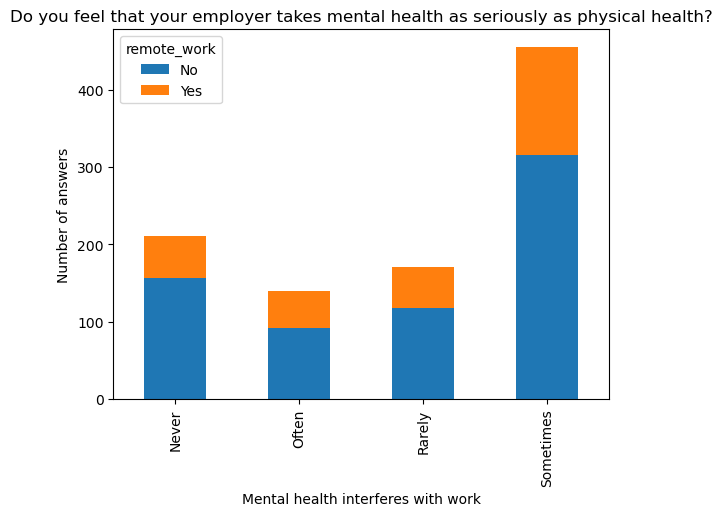

In [74]:
#mental vs remote

response_counts = df_sick.groupby('work_interfere')['remote_work'].value_counts().unstack()
response_counts.plot(kind='bar', stacked=True)
plt.title('Do you feel that your employer takes mental health as seriously as physical health?')
plt.xlabel('Mental health interferes with work')
plt.ylabel('Number of answers')

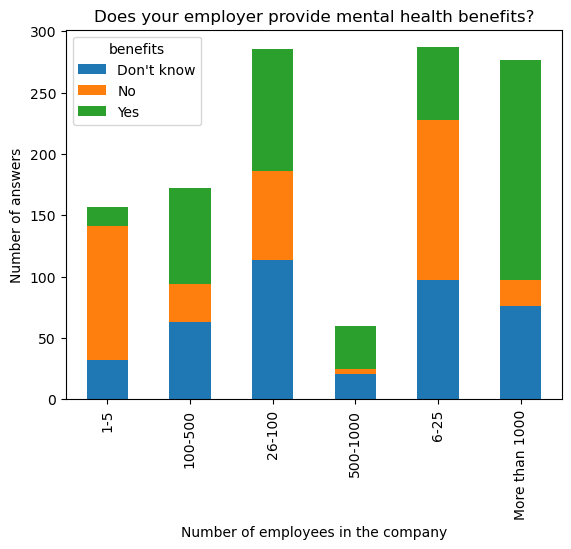

In [76]:
response_counts = df.groupby('no_employees')['benefits'].value_counts().unstack()
response_counts.plot(kind='bar', stacked=True)
plt.title('Does your employer provide mental health benefits?')
plt.xlabel('Number of employees in the company')
plt.ylabel('Number of answers')

plt.show()

In [82]:
#pomysły
# tech companies vs non tech
# all benefits in workplace yes/no

ValueError: could not convert string to float: 'United States'